<a href="https://colab.research.google.com/github/Vemula1207/Super-Resolution-of-Thermal-Images/blob/main/G28_FYP_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **G-28 : Object Detection using Thermal Super Resolution in Images**
#### **Members:** *Ashish Yadav, Rion Ghosh, Vemula Akhil, Pooja Parmar*
---
   
To detect Objects in Thermal Images, we require about 100+ thermal images of a certain class, and, similar amount for all the classes. Due to lack of such datasets, and non-availability of Thermal cameras in possession of our team members, the model was trained on a mix of Images, consisting of Thermal Images, as well as RGB Images, to increase the efficiency of Object Detection Model.

Here, we trained a model on a combined dataset of Thermal and RGB Images and have used the weights generated, on this cloud to be tested out by all the members of Group G-28. We have used [YOLO in Darkflow](https://github.com/thtrieu/darkflow) (the Tensorflow implementation of YOLO in Darkflow) to detect 15 classes of everyday objecs and animals, including bird, cat, airplane, bottle, tv and more.

## Installs
---
Run this code block (Play button inside the brackets on left). This installs and Imports the required dependencies for our project. It takes about 1-2 minutes to run and you can check the output beneath this block, to see  if any errors or warnings have being detected. After it is finished, scroll down to **Model Preparation**.

In [ ]:
# Install required libraries
!pip install tensorflow-gpu==1.15.0rc2
!pip install imageio

# Download and build darkflow (the tensorflow implementation of YOLO)
import os
import pathlib

if "darkflow-master" in pathlib.Path.cwd().parts:
  while "darkflow-master" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path("darkflow-master").exists():
  !git clone --depth 1 https://github.com/thtrieu/darkflow.git

  # Compile darkflow
  %cd darkflow
  !python setup.py build_ext --inplace

  # Change darkflow to darkflow-master to distinguish between folder names
  %cd ../
  !mv darkflow darkflow-master
  %cd darkflow-master

# Upload yolo.weights, pre-trained weights file (for YOLO v2) from an external Google drive
weights = 'yolo'
weights_file = weights + '.weights'
if not os.path.exists('weights_file'):
  !gdown --id 1w2IZDTpE3STYkhg1kXND2wVnbEx78H05
  !mkdir bin
  !mv yolo.weights bin

# Imports
%cd darkflow-master
%tensorflow_version 1.15.0rc2

# For importing/exporting files, working with arrays, etc
import time
import urllib
import numpy as np
import pandas as pd
import imageio

# For actual object detection
import tensorflow as tf
from darkflow.net.build import TFNet
threshold = 0.25

# For drawing onto and plotting images
import matplotlib.pyplot as plt
import cv2
%config InlineBackend.figure_format = 'svg'

# Download a Sample Image to Local System for later testing
%cd ../
!gdown --id 1Ye8J8-ZaaHYVV_XjsuizS9z6OkMWoDl7
!gdown --id 1Y26nlLXyFfY5Gzsh0K4T-gaO4ekrnq1_
!gdown --id 1qlWZt7xHmf1JR0Cim2tspDyLEeegP9HM

%cd darkflow-master

     |████████████████████████████████| 411.5MB 39kB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 3.8MB 32.1MB/s 
     |████████████████████████████████| 512kB 9.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=6f8d3c0c8fdb9cf99d10cf0b6f351c5312aab35b3466af9675fca27c3dab3d0c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing install

### Model Preparation
---   
Run this code block (Play button inside the brackets on left). This step takes ~30 seconds. This is the preparation of the model. This includes API that lets us use Images from URL's, direcly as if used from our local system (saving us from uploading all the Images), and, actual function that uses the weights and decides where put the bounding box and classes for it.<br> After it is finished, scroll down to **Object Detection!**

In [ ]:
# For uploading an image from url
# Modified from https://www.pyimagesearch.com/2015/03/02/convert-url-to-image-with-python-and-opencv/
def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

# Define parameters for feeding images through the model
# Can change detection confidence threshold here
params = {
    'model': 'cfg/yolo.cfg',
    'load': 'bin/yolo.weights',
    'threshold': threshold,
    'gpu': 1.0
}

# Run the model
tfnet = TFNet(params)

# For drawing bounding boxes around detected objects on image
def boxing(image, predictions):
    newImage = np.copy(image)
    im_height, im_width, im_depth = image.shape
    global labels
    labels = []
    for result in predictions:
      # Only show boxes that are above confidence threshold
      confidence = result['confidence']
      if confidence > threshold:
        xmin = result['topleft']['x']
        ymin = result['topleft']['y']
        xmax = result['bottomright']['x']
        ymax = result['bottomright']['y']
        #global label
        label = result['label'] + " " + str(round(confidence, 2))
        labels.append(label)
        # Draw boxes on image
        fontScale = max(im_width,im_height)/1000
        fontThickness = int(max(im_width,im_height)/400)
        newImage = cv2.rectangle(newImage, (xmin, ymax), (xmax, ymin), (255, 0, 157), 3)
        newImage = cv2.putText(newImage, label, (xmin, ymax-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 0, 0), fontThickness*2, cv2.LINE_AA)
        newImage = cv2.putText(newImage, label, (xmin, ymax-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255, 255, 255), fontThickness, cv2.LINE_AA)
    return newImage

Parsing ./cfg/yolo.cfg
Parsing cfg/yolo.cfg
Loading bin/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.02016758918762207s
Model has a coco model name, loading coco labels.

Building net ...

Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------



       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)

 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  | 

## Object Detection!
---
You can either **A) Load an image in by URL** or **B) Load an image in from file**.

**A) Load in individual image by URL**   
   
1. Copy the url and paste it within the quotes on line 2 in the code block below.
2. Drag your mouse over the brackets to the left of line 1 and press the "play" button on the right.
3. *Optional*: Adjust the detection confidence threshold on line 6 and press "play" again to display modified results.

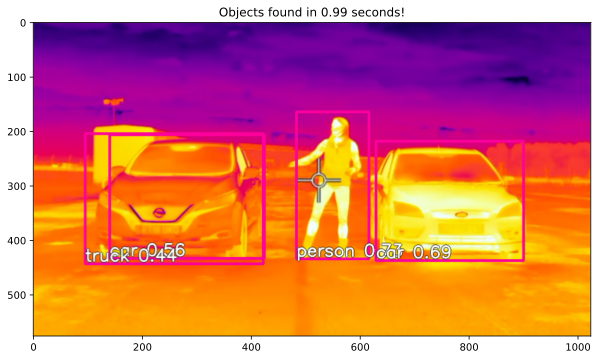

In [ ]:
# Insert your URL here
url = "https://s1.cdn.autoevolution.com/images/news/thermal-camera-video-shows-the-obvious-evs-are-more-energy-efficient-than-ice-c-139090_1.jpg"

# Set confidence threshold for detection
# Optional: You can adjust this value (0-1) to see more or less detected objects in the image
threshold = 0.3

# Read in image from URL
image = url_to_image(url)

# Use YOLO for object detection
# Record inference time
start_time = time.time()
result = tfnet.return_predict(image)
end_time = time.time()

# Plot and show detection boxes on images
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(boxing(image, result))
# Add titles to plot
if result and labels:
  plt.title('Objects found in {} seconds!'.format(format(end_time-start_time, '.2f')))
else:
  plt.title("Nothing detected in this picture :(")

**B) Load in individual image by file**   
Read in any image from file and see what objects YOLO can find!  
To get an image from file:  
1. Click the folder icon in the left side panel.
2. Click "Upload"
3. Select any image from your computer to upload.
4. Copy your image filename within the quotes on line 3 in the code block below.  
5. Drag your mouse over the brackets to the left of line 1 and press the "play" button on the right.
6. *Optional*: Adjust the detection confidence threshold on line 7 and press "play" again to display modified results.

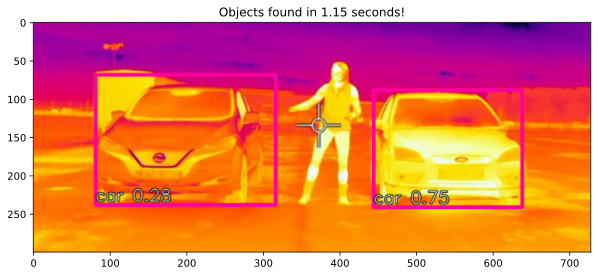

In [ ]:
# Insert your filename at line 3
inpath = '/content/'
filename = 'thermal_001-S.png'

# Set confidence threshold for detection
# Optional: You can adjust this value (0-1) to see more or less detected objects in the image
threshold = 0.25

# Read in image from file
fpath = inpath + filename
image = imageio.imread(fpath, pilmode='RGB')

# Use YOLO for object detection
# Record inference time
start_time = time.time()
result = tfnet.return_predict(image)
end_time = time.time()

# Plot and show detection boxes on images
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(boxing(image, result))
# Add titles to plot
if result and labels:
  plt.title('Objects found in {} seconds!'.format(format(end_time-start_time, '.2f')))
else:
  plt.title("Nothing detected in this picture :(")

## Tesing on Low vs Super-Resolution Image!
---
We will be demonstrating the use of Thermal Super Resolution in Object Detection by running the same model on <br>**A) Low Resolution Thermal Image** <br>**B) Same Image but Super Resolved through our model**

**A) Low Resolution Thermal Image Input**<br>
Below the Object detection model is used to detect any classes of Objects in a low resolution Thermal Image.<br>
*As you can see the model is able to pick up only certiain limited classes or in worst cases, no classes at all.*

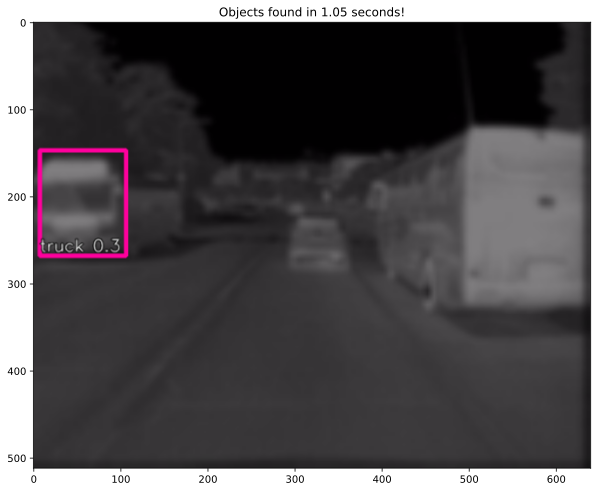

In [ ]:
# Path to Low Resolution Thermal Image is provided on line 3
inpath = '/content/'
filename = 'thermal-low-res-01.png'

# Set confidence threshold for detection
# Optional: You can adjust this value (0-1) to see more or less detected objects in the image
threshold = 0.3

# Read in image from file
fpath = inpath + filename
image = imageio.imread(fpath, pilmode='RGB')

# Use YOLO for object detection
# Record inference time
start_time = time.time()
result = tfnet.return_predict(image)
end_time = time.time()

# Plot and show detection boxes on images
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(boxing(image, result))
# Add titles to plot
if result and labels:
  plt.title('Objects found in {} seconds!'.format(format(end_time-start_time, '.2f')))
else:
  plt.title("Nothing detected in this picture :(")

**B) Same Image but Super Resolved through our model**<br>
Below the Object detection model is used to detect any classes of Objects in the same Image after it was Super Resolved by our Thermal SR.<br>
*As you can see the model is able to pick up more objects and with more accuracy.*

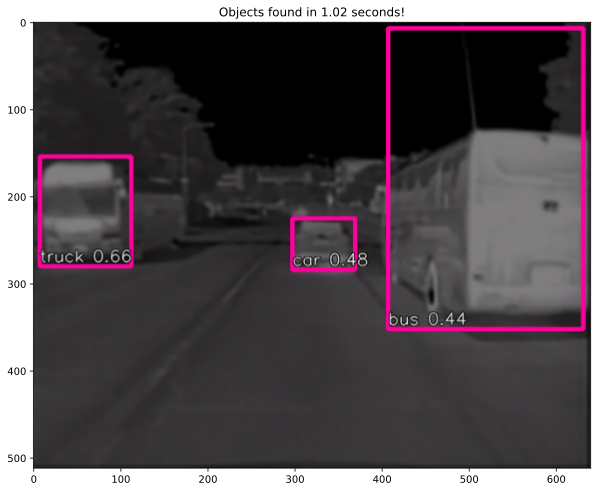

In [ ]:
# Path to Super Resolved Thermal Image is provided on line 3
inpath = '/content/'
filename = 'thermal-low-res-01-SR-output.png'

# Set confidence threshold for detection
# Optional: You can adjust this value (0-1) to see more or less detected objects in the image
threshold = 0.3

# Read in image from file
fpath = inpath + filename
image = imageio.imread(fpath, pilmode='RGB')

# Use YOLO for object detection
# Record inference time
start_time = time.time()
result = tfnet.return_predict(image)
end_time = time.time()

# Plot and show detection boxes on images
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(boxing(image, result))
# Add titles to plot
if result and labels:
  plt.title('Objects found in {} seconds!'.format(format(end_time-start_time, '.2f')))
else:
  plt.title("Nothing detected in this picture :(")